This notebook analyses data from a Luria-Delbrück fluctuation experiment. The data are stored in an Excel file under the directory "./data". Output plots are put into the directory "./plots". Run the notebook sequentially by clicking on a cell and pressing Shift+Enter. 

In [1]:
# Luria-Delbruck fluctuation assay

# First import required packages
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.special
from scipy import stats
from scipy.optimize import minimize
import pandas as pd
import os as os

# Define paths to input and output directories
INPATH = "./data/"
OUTPATH = "./plots/"

# Generate output directory if not already present
if not os.path.exists(OUTPATH):
    os.mkdir(OUTPATH)

In [2]:
# Define all required functions

def Poissondistribution(m,N):
# Infinite Poisson distribution

    r = np.linspace(0,N-1,N)
    pr = np.zeros(N)
    pr = poisson.pmf(r, m) 

    return(r,pr)

def LDdistributionInf(m,N):
# Infinite Luria-Delbruck distribution

    r = np.linspace(0,N,N+1)
    pr = np.zeros(N)
    
    pr[0] = np.exp(-m)
    for j in range(1,N):
        prtemp = 0
        for i in range(0,j):
            prtemp += m/j * pr[i]/(j - i + 1) 
        pr[j] = prtemp
        
    return(r[:-1], np.array(pr))

def LL(params,dataMut,counts):
# Log likelihood function    

    m = params[0]
    
    r,pr = LDdistributionInf(m,int(max(dataMut)))
    
    ypred = pr
    ydat = counts/np.sum(counts)   
    LL = -np.sum(stats.norm.logpdf(ydat, loc=ypred))
    return(LL)

def LLPoisson(params,dataMut,counts):
# Log likelihood function    

    m = params[0]
    
    r,pr = Poissondistribution(m,int(max(dataMut)))
    
    ypred = pr
    ydat = counts/np.sum(counts)   
    LL = -np.sum(stats.norm.logpdf(ydat, loc=ypred))
    return(LL)


def analyse_p0(dataMut, cellCounts):
    
    # remove NaN
    cellCounts = cellCounts[~np.isnan(cellCounts)]
    
    Nexpts = len(dataMut) # Number of different cultures
    Ncells = np.median(cellCounts) # If combining from different bulks, take median
    counts,locs=np.histogram(dataMut,int(max(dataMut)))
    
    # 1. Calculate m using p0 method
    p0 = counts[0]/Nexpts
    mfit = -np.log(p0)
    mu = mfit/Ncells

    print('p0 method yields:')
    print('m = '+str("{:.2E}".format(mfit))+" mutations per culture") 
    print('mu = '+str("{:.2E}".format(mu))+" mutations per cell division")
    print("")
    
def analyse_LD(dataMut, cellCounts):
    
    # remove NaN
    cellCounts = cellCounts[~np.isnan(cellCounts)]
    
    Nexpts = len(dataMut) # Number of different cultures
    Ncells = np.median(cellCounts) # If combining from different bulks, take median
    counts,locs=np.histogram(dataMut,int(max(dataMut)))
    
    # Calculate m using max-likelihood fitting
    
    initParams = [1] # initial guess for m
    results = minimize(LL, initParams, args = (dataMut,counts), method='Nelder-Mead')
    mfit = results.x # Fitted m
    mfit = mfit[0]
    
    # Calculate confidence intervals
    sigma = 1.225*mfit**(-0.315)/np.sqrt(Nexpts)
    m95minus = np.exp(np.log(mfit) - 1.96*sigma*(np.exp(1.96*sigma))**0.315)
    m95plus = np.exp(np.log(mfit) + 1.96*sigma*(np.exp(1.96*sigma))**-0.315)
    
    r,pr = LDdistributionInf(mfit,int(max(dataMut)))
    r,prplus = LDdistributionInf(m95plus,int(max(dataMut)))
    r,prminus = LDdistributionInf(m95minus,int(max(dataMut)))

    print('Maximum-likelihood fitting yields:')
    print('m95- = '+str("{:.2E}".format(mfit-m95minus)))
    print('m = '+str("{:.2E}".format(mfit))+" mutations per culture")
    print('m95+ = '+str("{:.2E}".format(m95plus-mfit)))
    print('mu 95- = '+str("{:.2E}".format((mfit-m95minus)/Ncells)))
    print('mu = '+str("{:.2E}".format(mfit/Ncells))+" mutations per cell division")
    print('mu 95+ = '+str("{:.2E}".format((m95plus-mfit)/Ncells)))

    return(r,pr,prplus,prminus)  

def analyse_Poisson(dataMut, cellCounts):
    
    # remove NaN
    cellCounts = cellCounts[~np.isnan(cellCounts)]
    
    Nexpts = len(dataMut) # Number of different cultures
    Ncells = np.median(cellCounts) # If combining from different bulks, take median
    counts,locs=np.histogram(dataMut,int(max(dataMut)))
    
    # Calculate m using max-likelihood fitting
    
    initParams = [1] # initial guess for m
    results = minimize(LLPoisson, initParams, args = (dataMut,counts), method='Nelder-Mead')
    mfit = results.x # Fitted m
    mfit = mfit[0]
    
    # Calculate confidence intervals
    sigma = np.sqrt(mfit/Nexpts)
    m95minus = mfit - 1.96*sigma
    m95plus = mfit + 1.96*sigma
    
    r,pr = Poissondistribution(mfit,int(max(dataMut)))
    r,prplus = Poissondistribution(m95plus,int(max(dataMut)))
    r,prminus = Poissondistribution(m95minus,int(max(dataMut)))

    print('Maximum-likelihood fitting yields:')
    print('m95- = '+str("{:.2E}".format(mfit-m95minus)))
    print('m = '+str("{:.2E}".format(mfit))+" mutations per culture")
    print('m95+ = '+str("{:.2E}".format(m95plus-mfit)))
    print('mu 95- = '+str("{:.2E}".format((mfit-m95minus)/Ncells)))
    print('mu = '+str("{:.2E}".format(mfit/Ncells))+" mutations per cell division")
    print('mu 95+ = '+str("{:.2E}".format((m95plus-mfit)/Ncells)))

    return(r,pr,prplus,prminus)  
    
def plotLD(r,pr,prplus,prminus,dataMut,XLIM,YLIM,NAME,nBins):
    
    if nBins==False:
        nBins= int(max(dataMut))
    else:
        nBins = nBins
        
    plt.close("all"); DPI=300
    figure_options={'figsize':(8.27,5.83)} # figure size in inches. A4=11.7x8.3. A5=8.27,5.83
    font_options={'size':'22','family':'sans-serif','sans-serif':'Arial'}
    plt.rc('figure', **figure_options)
    plt.rc('font', **font_options)

    Nexpts = len(dataMut) # Number of different cultures
    # Plot results

    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95) # Set size of plot precisely
    ax.hist(dataMut,bins=nBins,alpha=0.5)
    
    ax.plot(r,pr*Nexpts,'r')
    ax.plot(r,prplus*Nexpts,'r--',alpha=0.5)
    ax.plot(r,prminus*Nexpts,'r--',alpha=0.5)
    
    ax.set_ylabel('Number of cultures')
    ax.set_xlabel('Number of mutants')
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    
    plt.savefig(OUTPATH+"class_histLD"+NAME+".png",transparent=True); 
    plt.show()

def plotPoisson(r,pr,prplus,prminus,dataMut,XLIM,YLIM,NAME,nBins):

    if nBins==False:
        nBins= int(max(dataMut))
    else:
        nBins = nBins
        
    plt.close("all"); DPI=300
    figure_options={'figsize':(8.27,5.83)} # figure size in inches. A4=11.7x8.3. A5=8.27,5.83
    font_options={'size':'22','family':'sans-serif','sans-serif':'Arial'}
    plt.rc('figure', **figure_options)
    plt.rc('font', **font_options)
    
    Nexpts = len(dataMut) # Number of different cultures
    # Plot results

    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95) # Set size of plot precisely
    ax.hist(dataMut,bins=nBins,alpha=0.5)
    
    ax.plot(r,pr*Nexpts,'b')
    ax.plot(r,prplus*Nexpts,'b--',alpha=0.5)
    ax.plot(r,prminus*Nexpts,'b--',alpha=0.5)
    
    ax.set_ylabel('Number of cultures')
    ax.set_xlabel('Number of mutants')
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    
    plt.savefig(OUTPATH+"class_histPoisson"+NAME+".png",transparent=True); 
    plt.show()

The analysis happens below. We analyse the red and white colony counts separately.

p0 method yields:
m = 7.27E-01 mutations per culture
mu = 1.71E-07 mutations per cell division

Maximum-likelihood fitting yields:
m95- = 7.63E-02
m = 6.91E-01 mutations per culture
m95+ = 7.96E-02
mu 95- = 1.80E-08
mu = 1.63E-07 mutations per cell division
mu 95+ = 1.87E-08


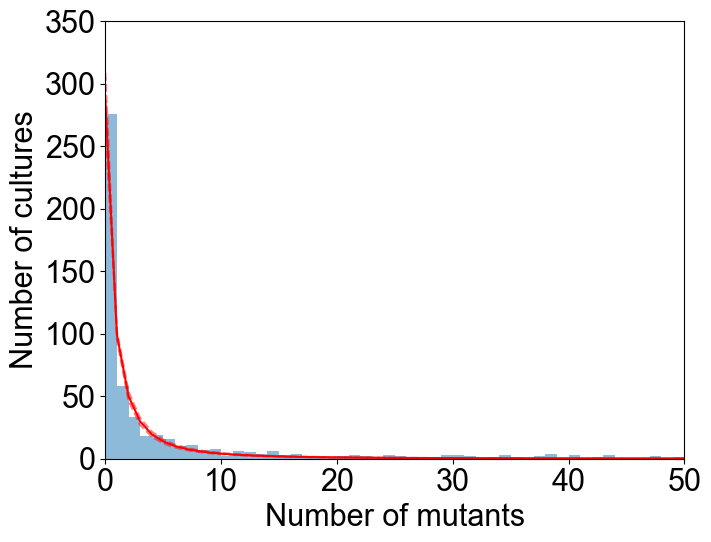

In [3]:
# Analyse data Reds

# Import data
xls = pd.ExcelFile(INPATH+"sampledata.xlsx")
df1 = pd.read_excel(xls,sheet_name=0)

# The data records, for each individual culture, 
# 1. the number of mutant colonies ('dataMut')
# 2. and the total number of cells in that culture ('cellCounts').

# The red and white colonies are analysed separately. 

# Choose the data we want
dataMut = df1.iloc[:,0].values
cellCounts = df1.iloc[:,2].values

# 1. Apply p0 method:
analyse_p0(dataMut, cellCounts)

# 2. Analyse and plot Luria-Delbruck distribution
r,pr,prplus,prminus = analyse_LD(dataMut, cellCounts)
plotLD(r,pr,prplus,prminus,dataMut,XLIM=[0,50],YLIM=[0,350],NAME="Reds",nBins=False)

# 3. Analyse and plot Poisson distribution
#r,pr,prplus,prminus = analyse_Poisson(dataMut, cellCounts)
#plotPoisson(r,pr,prplus,prminus,dataMut,XLIM=[0,50],YLIM=[0,350],NAME="Reds",nBins=False)


p0 method yields:
m = 1.64E+00 mutations per culture
mu = 3.85E-07 mutations per cell division

Maximum-likelihood fitting yields:
m95- = 1.39E-01
m = 1.64E+00 mutations per culture
m95+ = 1.43E-01
mu 95- = 3.27E-08
mu = 3.86E-07 mutations per cell division
mu 95+ = 3.37E-08


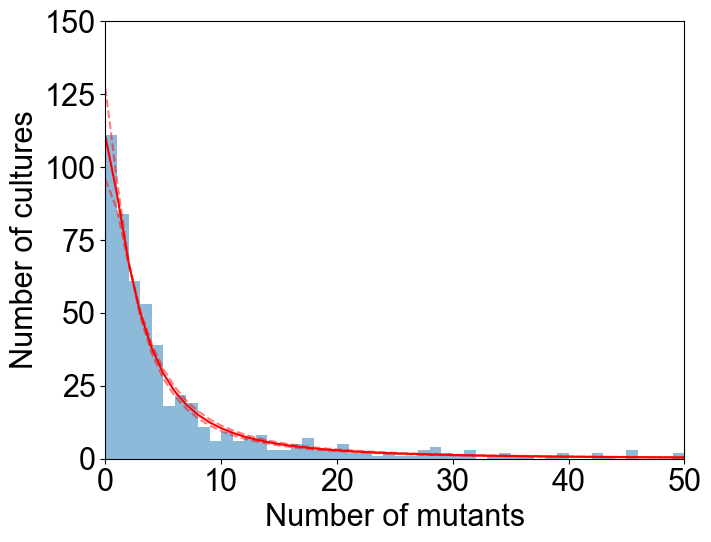

In [4]:
# Analyse data Whites

# Import data
xls = pd.ExcelFile(INPATH+"sampledata.xlsx")
df1 = pd.read_excel(xls,sheet_name=0)

# The data records, for each individual culture, 
# 1. the number of mutant colonies ('dataMut')
# 2. and the total number of cells in that culture ('cellCounts').

# The red and white colonies are analysed separately. 

# Choose the data we want
dataMut = df1.iloc[:,1].values 
cellCounts = df1.iloc[:,2].values

# 1. Apply p0 method:
analyse_p0(dataMut, cellCounts)

# 2. Analyse and plot Luria-Delbruck distribution
r,pr,prplus,prminus = analyse_LD(dataMut, cellCounts)
plotLD(r,pr,prplus,prminus,dataMut,XLIM=[0,50],YLIM=[0,150],NAME="Whites",nBins=False)

# 3. Analyse and plot Poisson distribution
#r,pr,prplus,prminus = analyse_Poisson(dataMut, cellCounts)
#plotPoisson(r,pr,prplus,prminus,dataMut,XLIM=[0,50],YLIM=[0,150],NAME="Whites",nBins=False)


We observe that the Luria-Delbrück distribution fits the data remarkably well. The white colonies occur with a higher mutation rate than the red colonies. Finally, the p0 method is also an excellent way to determine mutation rate, and its predictions are very close to that obtained by fitting the full distribution. However as discussed in the class, the p0 method is unreliable when the sample size is small.